In [2]:
%%capture
!pip install mne
import os
from glob import glob
import numpy as np
import pandas as pd
import mne
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
import os
import glob
import numpy as np
import mne
import pandas as pd
import random
#import tensorflow as tf
#import matplotlib.pyplot as plt
#import warnings
#from pathlib import Path
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import train_test_split
#from scipy.io import loadmat
#from scipy.signal import butter, lfilter
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
raw = mne.io.read_raw_brainvision("/content/drive/MyDrive/eeg-data-row/session1_sub11_reaching_realMove.vhdr", misc='auto', scale=1.0, preload=True, verbose=None)
events = mne.events_from_annotations(raw)

event_ids = {'Stimulus/S 11': 11,'Stimulus/S 21': 21,'Stimulus/S 31': 31,'Stimulus/S 41': 41,'Stimulus/S 51': 51,'Stimulus/S 61': 61}
epochs = mne.Epochs(raw, events[0], event_id=event_ids, tmin=0, tmax=4, preload=True,baseline=(0, 0))

Extracting parameters from /content/drive/MyDrive/eeg-data-row/session1_sub11_reaching_realMove.vhdr...
Setting channel info structure...
Reading 0 ... 8488199  =      0.000 ...  3395.280 secs...
Used Annotations descriptions: ['Comment/actiCAP Active Shield On', 'Comment/actiCAP Data On', 'New Segment/', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  3', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  8', 'Stimulus/S 11', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 21', 'Stimulus/S 31', 'Stimulus/S 41', 'Stimulus/S 51', 'Stimulus/S 61']
Not setting metadata
300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 10001 original time points ...
0 bad epochs dropped


In [6]:
import pywt
from pywt import wavedec
coeffs = wavedec(epochs, 'db4' , level=6)
len(coeffs)

7

In [7]:
coeffs_ = np.array(coeffs[6])
coeffs_.shape

(300, 71, 5004)

In [8]:
statCoff= np.log (np.var(coeffs_,axis=1))
statCoff.shape

(300, 5004)

In [9]:
labels = np.empty(shape=(300))
decode = {11: 0, 21: 1, 31: 2, 41:3, 51: 4, 61: 5, 8 :6}
k=0
for i in epochs.events:
    labels[k]=decode[i[2]]
    k+=1

In [10]:
labels.shape

(300,)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(statCoff, labels, test_size = 0.2,stratify=labels,shuffle=True)

In [12]:
X_train.shape , X_val.shape , y_train.shape , y_val.shape

((240, 5004), (60, 5004), (240,), (60,))

In [13]:
from sklearn import svm
from sklearn import metrics

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_val)

print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.8666666666666667


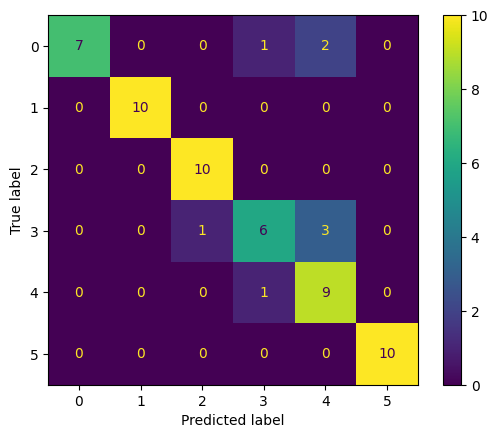

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay ,confusion_matrix

cm=confusion_matrix(y_val,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()


In [25]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(X_train.shape[1],), activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_val, y_val))
#"rmsprop"
# optim=tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer=optim,
#               loss="sparse_categorical_crossentropy",
#               metrics=["accuracy"])
# training_results = model.fit(X_train, 
#                              y_train, 
#                              epochs=50, 
#                              batch_size=16, 
#                              validation_data=(X_val, y_val));

Epoch 1/300
8/8 [==============================] - 2s 63ms/step - loss: 48.8865 - accuracy: 0.1583 - val_loss: 41.4367 - val_accuracy: 0.1667
Epoch 2/300
8/8 [==============================] - 0s 19ms/step - loss: 37.4136 - accuracy: 0.1417 - val_loss: 19.1873 - val_accuracy: 0.1667
Epoch 3/300
8/8 [==============================] - 0s 17ms/step - loss: 18.9036 - accuracy: 0.1333 - val_loss: 17.2832 - val_accuracy: 0.1667
Epoch 4/300
8/8 [==============================] - 0s 21ms/step - loss: 16.3215 - accuracy: 0.1792 - val_loss: 11.5984 - val_accuracy: 0.1667
Epoch 5/300
8/8 [==============================] - 0s 23ms/step - loss: 8.6995 - accuracy: 0.2042 - val_loss: 6.8359 - val_accuracy: 0.1667
Epoch 6/300
8/8 [==============================] - 0s 18ms/step - loss: 6.4341 - accuracy: 0.1250 - val_loss: 8.5437 - val_accuracy: 0.1667
Epoch 7/300
8/8 [==============================] - 0s 18ms/step - loss: 7.3042 - accuracy: 0.1542 - val_loss: 10.2158 - val_accuracy: 0.1667
Epoch 8/300

In [26]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc)

2/2 [==============================] - 0s 8ms/step - loss: 0.5834 - accuracy: 0.8833
Test accuracy: 0.8833333253860474


2/2 [==============================] - 0s 6ms/step


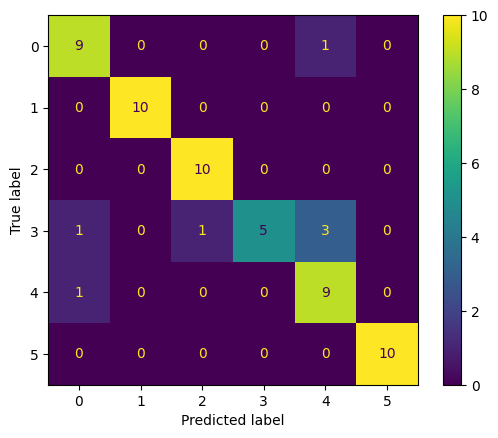

In [27]:
y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
from sklearn.metrics import ConfusionMatrixDisplay ,confusion_matrix

cm=confusion_matrix(y_val,y_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot()
